In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# from sklearn.metrics import classification_report


In [2]:
folder_name = input("Please enter the subject name: ")

Define the dataset

In [3]:
# Define the column names
column_names = ['FZ', 'FC1', 'FC2', 'C3', 'CZ', 'C4', 'CPZ', 'PZ', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']
df = []
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            df_temp = pd.read_csv(file_path, header=None)
            df.append(df_temp)     
    combined_data_array_3d = np.array(df)
    combined_data_array_2d= combined_data_array_3d.reshape(40 * 10000, 21)
    
Combined_raw_eeg = pd.DataFrame(combined_data_array_2d) 
Combined_raw_eeg.columns = column_names

#Excluding the useless columns
columns_to_remove = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Battery', 'Sample', 'Unknown','Instruction','Female/Male', 'Outdoor/Indoor', 'Human Behavior']
Combined_raw_eeg = Combined_raw_eeg.drop(columns=columns_to_remove, axis=1)

In [4]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

Combined_raw_eeg_bp = np.copy(Combined_raw_eeg)
num_columns = Combined_raw_eeg_bp.shape[1]

for column in range(num_columns):
    Combined_raw_eeg_bp[:, column] = butter_bandpass_filter(Combined_raw_eeg_bp[:, column], lowcut=.4, highcut=40, fs=250)

In [5]:
# Pre-proccessing
# Denoising 
def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

Combined_raw_eeg_bp=pd.DataFrame(Combined_raw_eeg_bp)
eeg_df_denoised = preprocess(Combined_raw_eeg_bp, col_names=list(Combined_raw_eeg_bp.columns), n_clusters=[50]*len(Combined_raw_eeg_bp.columns))

In [6]:
# Lableing
column_indices = {'Instruction': 17, 'Female/Male': 18, 'Outdoor/Indoor': 19}
selected_columns = [column_indices['Instruction'], column_indices['Female/Male'], column_indices['Outdoor/Indoor']]
data_im_ins = combined_data_array_2d[:, selected_columns]
denoised_im_ins = np.concatenate((eeg_df_denoised, data_im_ins), axis=1)

# Check the third last column (column 9) and keep rows if column 9 is equal to 1
filtered_denoised_im_ins = denoised_im_ins[(denoised_im_ins[:, -3] == denoised_im_ins[:, -2]) | (denoised_im_ins[:, -3] == denoised_im_ins[:, -1])]
filtered_denoised_im_ins_df = pd.DataFrame(filtered_denoised_im_ins)

# Create a new column 'event'
filtered_denoised_im_ins_df['event'] = ''
for index, row in filtered_denoised_im_ins_df.iterrows():
    if row.iloc[-4] == 'F' or row.iloc[-4] == 'M':
        filtered_denoised_im_ins_df.at[index, 'event'] = '0'
    elif row.iloc[-4] == 'I' or row.iloc[-4] == 'O':
        filtered_denoised_im_ins_df.at[index, 'event'] = '1'
        
selected_data = filtered_denoised_im_ins_df.iloc[:, :8]  
lable=filtered_denoised_im_ins_df.iloc[:, -1:]

In [7]:
print(selected_data.shape)

(360000, 8)


Windowing

In [8]:
win_size = 250
X = []
y = []

for i in range(0, len(selected_data), win_size):
    window_data = selected_data.iloc[i:i+win_size]
    window_label = lable.iloc[i:i+win_size]
    X.append(window_data)
    y.append(window_label)

X = np.array(X)
y = np.array(y)
X, y = shuffle(X, y)

In [9]:
print(X.shape, y.shape)

(1440, 250, 8) (1440, 250, 1)


In [50]:
X[:,:, 7].shape


(1440, 250)

In [55]:
X.shape[2]

8

In [ ]:
import numpy as np
from scipy.signal import find_peaks

# data is in a 2D numpy array 'data' with shape (1440, 8)
# event timestamps are in a list 'event_timestamps'
# sample rate of 250Hz

for n in range(0, len(data_target), epoch_size):
    epoch_signal = data_target.iloc[n:n+epoch_size]
    time = (n*epoch_size)/(1*fs)
    time_list.append(time)
    




sample_rate = 250  # adjust this if your sample rate is different
time_window = sample_rate * 1  # 1 second window

# initialize empty lists to hold your features
features = []

# loop over your channels
time_list=[]
for channel in range(X.shape[2]):
    # loop over your ERPs
    for event_timestamp in event_timestamps:
        # convert the event timestamp to a sample index
        event_index = int(event_timestamp * sample_rate)
        # extract the ERP
        erp = eeg_data_pca[event_index:event_index + time_window, channel]
        # find the peak
        peaks, _ = find_peaks(erp)
        # check if peaks were found, if not, continue to next iteration
        if len(peaks) == 0:
            continue
        # get the amplitude and latency of the largest peak
        peak_amplitude = np.max(erp[peaks])
        peak_latency = np.argmax(erp[peaks]) / sample_rate
        # append the features to your list
        features.append([channel, peak_amplitude, peak_latency])

features = np.array(features)

In [22]:
array_3d = X.reshape(1440, 250*8)
print(array_3d.shape)


(1440, 2000)


In [24]:
X.shape[1]

250

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# standardize features
scaler = StandardScaler()
eeg_data_standardized = scaler.fit_transform(array_3d)

# perform PCA
pca = PCA(n_components=400)  # how many components you want to keep
pca.fit(eeg_data_standardized)
eeg_data_pca = pca.transform(eeg_data_standardized)

# Now eeg_data_pca contains your data with reduced dimensions


In [13]:
print(eeg_data_pca.shape)

(1440, 400)


In [14]:
y_n=np.squeeze(y[:,0])
print(y_n.shape)
# print(y_n[20], y[20])

(1440,)


Feature Extraction for SVM

In [15]:
# Hilbert feature extraction
analytic_signal = hilbert(eeg_data_pca)
envelope = np.abs(analytic_signal)
envelope=np.hstack((envelope, eeg_data_pca))

# selected_dataf=selected_data
print(envelope.shape)


(1440, 800)


In [16]:
eeg_data_pca.shape[1]

400

Splitting the data to test and train

In [17]:
X_n = envelope
y_n=np.squeeze(y[:,0])
print(X_n.shape, y_n.shape)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_n, y_n)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)

(1440, 800) (1440,)


In [18]:
# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_untouch = np.argmax(y_untouch, axis=-1)

print(y_train.shape, y_test.shape)

(1166,) (130,)


In [19]:
print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

X_train: (1166, 800) y_train: (1166,) X_test: (130, 800) y_test: (130,) X_untouch: (144, 800) y_untouch: (144,)


SVM

In [20]:

from sklearn import svm
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)




report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)


Model accuracy:  0.6461538461538462
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        71
           1       0.59      0.71      0.65        59

    accuracy                           0.65       130
   macro avg       0.65      0.65      0.65       130
weighted avg       0.66      0.65      0.65       130



Accuracy: 0.5972222222222222
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.51      0.55        69
           1       0.60      0.68      0.64        75

    accuracy                           0.60       144
   macro avg       0.60      0.59      0.59       144
weighted avg       0.60      0.60      0.59       144



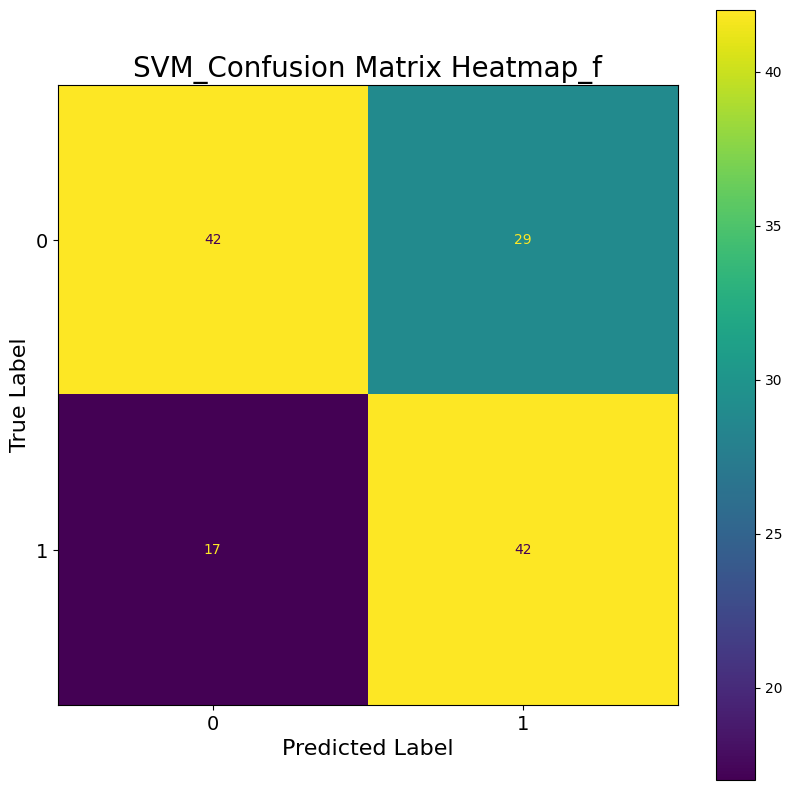

In [21]:
# Predict on the untouched data

y_pred_untouch = clf.predict(X_untouch)
# Calculate accuracy
accuracy_svm = accuracy_score(y_untouch, y_pred_untouch)
print('Accuracy:', accuracy_svm)
report_svm = classification_report(y_untouch, y_pred_untouch)
print("Classification Report:")
print(report_svm)
report_df_svm.to_excel(f"svm_validation_{folder_name}.xlsx", index=True)

# Compute the confusion matrix
cm_svm= confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm_svm).plot(ax=ax, cmap='viridis')
plt.title(f'SVM_Confusion Matrix Heatmap_{folder_name}', fontsize=20)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'SVM_confusion_matrix_heatmap_{folder_name}.png', dpi=300)
plt.show()